In [1]:
import pandas as pd
import numpy as np
import json
import yaml
import scikit_posthocs as sp
from scipy import stats

from matplotlib import pyplot as plt

from scipy.stats import wilcoxon, friedmanchisquare, rankdata
from Orange.evaluation import compute_CD, graph_ranks

In [154]:
def compute_plot_Nemenyi(data, filename, model ="resnet50", dataset = "imagenet"):
    ranks = np.array([rankdata(-p) for p in data.values])
    average_ranks = np.mean(ranks, axis=0)
    cd = compute_CD(average_ranks,
                    n=data.shape[0],
                    alpha='0.05',
                    test='nemenyi')
    # This method generates the plot.
    graph_ranks(average_ranks,
                names=list(data),
                cd=cd,
                width=10,
                textspace=2,
                reverse=True)

    plt.savefig(f'results/{filename}_{model}_{dataset}.png')
    plt.close()

In [161]:
def parser_method_dict(df, batch = 16):
    ''''This function parse the dict and then compute the AUC per image
        It returns a dataframe of the shape (Batch, Nb_images_per_bach)
        np.trapz integrates the function under the curve
    '''
    dataf = pd.DataFrame(columns = [f"{i}" for i in range(batch)])
    for i in range(df.shape[0]):
        row = yaml.safe_load(df.iloc[i].iloc[0])
        dataf.loc[i] = [np.trapz(row[j]) for j in row]
    #print(dataf)
    return dataf

In [162]:
metrics =  ['Monotonicity Nguyen',  'Local Lipschitz Estimate',
            'Faithfulness Estimate', 'Faithfulness Correlation', 
            'Avg-Sensitivity', 'Random Logit',
            'Max-Sensitivity', 'Sparseness', 
            'EffectiveComplexity', 'Nonsensitivity',
             'Complexity', 'Pixel-Flipping',
            "Selectivity"]  # ['SensitivityN', 'Model Parameter Randomisation', 'Selectivity', 
                #'Region Perturbation', 'Pixel-Flipping', 'Monotonicity Arya',  'Continuity Test', 'Completeness']
    
transform = {'Monotonicity Nguyen': abs, 'Local Lipschitz Estimate': lambda x: -x, 
            'Faithfulness Estimate': abs, 'Faithfulness Correlation': abs, 
            'Avg-Sensitivity': lambda x: -x, 'Random Logit': lambda x: x,
             'Sparseness': lambda x: x, 'EffectiveComplexity': lambda x: -x,
             'Nonsensitivity': lambda x: -x, 'Pixel-Flipping': lambda x: x.apply(lambda row: - np.trapz(row), axis=1),
             'Max-Sensitivity': lambda x: -x, 'Complexity': lambda x: -x, 
             "Selectivity": lambda x: -parser_method_dict(x),
            }

    
methods = ['integratedgrad', 'smoothgrad', 'guidedbackprop', 'rise', 'gradcam', 'scorecam', 'layercam', 'random', 'sobel', "gaussian", "polycam"]



model = "resnet50"

dico_ranks = {}
alpha = 0.05 #Seuil de significativité

group_nemenyi = {}

dataset = "imagenet"
for metr in metrics:
    data_nemenyi = pd.DataFrame()
    print("-- Metric: ", metr)
    for meth in methods:
        csv_name = f"csv/{meth}_{model}_{dataset}_{metr}.csv"
        df = pd.read_csv(csv_name, header = None)
        data_nemenyi[meth] = transform[metr](df).values.flatten()

    #data_nemenyi = transform[metr](data_nemenyi)
    
    ranks = np.array([rankdata(-p) for p in data_nemenyi.values])
    average_ranks = np.mean(ranks, axis=0)
    
    dico_ranks[metr] = average_ranks/len(metrics)
    
    result = sp.posthoc_nemenyi_friedman(data_nemenyi)
    #Order of methods in changed after passed to the previous function
    meth_names = result.index.values.tolist()
    
    group_nemenyi[metr] = np.argwhere(result.reindex(methods)[methods].values > 0.005)

df_ranks = pd.DataFrame(dico_ranks, index= methods)

compute_plot_Nemenyi(data= data_nemenyi, filename= metr)

-- Metric:  Monotonicity Nguyen
-- Metric:  Local Lipschitz Estimate
-- Metric:  Faithfulness Estimate
-- Metric:  Faithfulness Correlation
-- Metric:  Avg-Sensitivity
-- Metric:  Random Logit
-- Metric:  Max-Sensitivity
-- Metric:  Sparseness
-- Metric:  EffectiveComplexity
-- Metric:  Nonsensitivity
-- Metric:  Complexity
-- Metric:  Pixel-Flipping
-- Metric:  Selectivity


In [163]:
df_ranks

,Monotonicity Nguyen,Local Lipschitz Estimate,Faithfulness Estimate,Faithfulness Correlation,Avg-Sensitivity,Random Logit,Max-Sensitivity,Sparseness,EffectiveComplexity,Nonsensitivity,Complexity,Pixel-Flipping,Selectivity
integratedgrad,0.501731,0.140923,0.520308,0.482885,0.189154,0.212538,0.189192,0.173731,0.260423,0.461538,0.172885,0.369346,0.312346
smoothgrad,0.365154,0.282731,0.395538,0.450462,0.076923,0.168192,0.076923,0.547462,0.643308,0.461538,0.558269,0.481846,0.402154
guidedbackprop,0.452673,0.115462,0.607154,0.501000,0.196885,0.174500,0.196885,0.086385,0.166115,0.461538,0.085385,0.230346,0.390346
rise,0.491269,0.725808,0.387154,0.430962,0.799500,0.555154,0.799577,0.803385,0.632750,0.461538,0.799385,0.476846,0.427615
gradcam,0.385404,0.481115,0.360615,0.433154,0.408231,0.458500,0.408308,0.363000,0.272635,0.461538,0.360192,0.566885,0.578154
scorecam,0.403596,0.537346,0.388423,0.438269,0.451692,0.534615,0.451654,0.476462,0.452442,0.461538,0.472846,0.586500,0.570462
layercam,0.394654,0.715462,0.385154,0.451231,0.605538,0.673385,0.605731,0.659769,0.643308,0.461538,0.657923,0.558538,0.567038
random,0.642192,0.630962,0.784423,0.514615,0.553423,0.843962,0.553154,0.522269,0.540212,0.461538,0.512269,0.344269,0.294192
sobel,0.530000,0.240962,0.468846,0.485269,0.792154,0.276038,0.792115,0.250154,0.460173,0.461538,0.251385,0.403538,0.438346
gaussian,0.513000,0.818769,0.380385,0.456038,0.693269,0.760808,0.693269,0.788385,0.643308,0.461538,0.792923,0.529423,0.550692


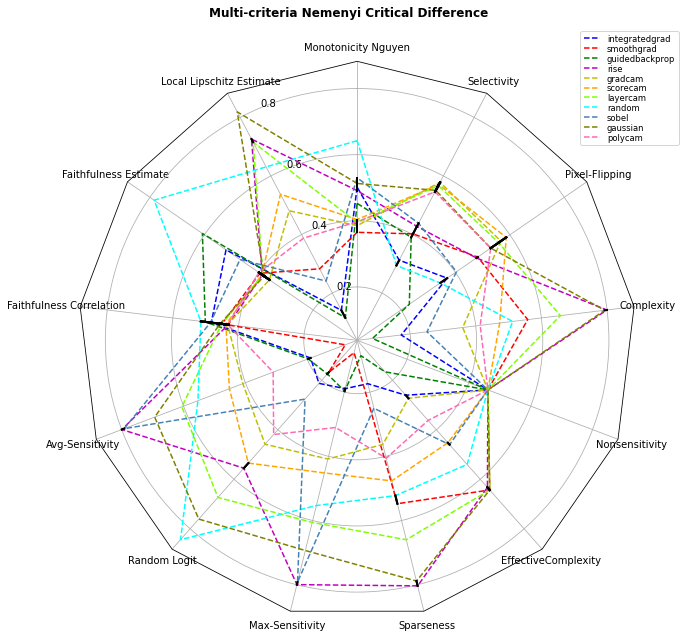

In [164]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------dx=1.0
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'
        # use 1 line segment to connect specified points
        RESOLUTION = 1

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


data = [metrics,
        ("toto", df_ranks.values)]

N = len(data[0])
theta = radar_factory(N, frame='polygon')

colors = ['b', 'r', 'g', 'm', 'y', "orange", "chartreuse", "cyan", "steelblue", "olive", "hotpink"]

spoke_labels = metrics

fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=1,
                             subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)


ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
# ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
#                     horizontalalignment='center', verticalalignment='center')
for i, color in enumerate(colors):
    ax.plot(theta, df_ranks.values[i], '--', color=color)
    #ax.fill(theta, df_ranks.values[i], facecolor=color, alpha=0.2)

# Plot Nemenyi groups
for p, metr in enumerate(metrics):
    gprs = group_nemenyi[metr]
    
    #Plot the critical difference
    for i in range(gprs.shape[0]):
        ax.plot(theta[[p,p]], df_ranks[metr].values[list(gprs[i])], color ="black", linewidth=2.0 ) 
        
    ax.plot()
ax.set_varlabels(spoke_labels)

labels = methods
legend = ax.legend(labels, loc=(0.9, 0.85),
                       labelspacing=0.1, fontsize='small')

fig.text(0.5, 0.9, 'Multi-criteria Nemenyi Critical Difference',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

plt.savefig("Nemenyi_multi.png")
plt.show()


In [6]:
# data_nemenyi = pd.DataFrame()
# metr = "Complexity"
# for meth in methods:
#     csv_name = f"csv/{meth}_{model}_{dataset}_{metr}.csv"
#     df = pd.read_csv(csv_name, header = None)
#     data_nemenyi[meth] = df.values.flatten()

# data_nemenyi = transform[metr](data_nemenyi)
# data_nemenyi

,integratedgrad,smoothgrad,guidedbackprop,rise,gradcam,scorecam,layercam,random,sobel,gaussian,polycam
0,-10.124887,-10.725508,-9.515084,-10.784378,-10.544789,-10.635494,-10.697947,-10.629024,-10.647035,-10.802211,-10.625124
1,-10.157261,-10.565333,-9.817596,-10.807300,-10.467514,-10.596388,-10.682541,-10.628732,-10.213099,-10.802211,-10.558668
2,-10.034280,-10.643705,-9.888752,-10.804773,-10.520086,-10.611506,-10.689564,-10.631625,-10.323938,-10.802211,-10.574060
3,-10.234270,-10.616492,-9.949436,-10.817055,-10.449071,-10.519314,-10.633806,-10.632387,-10.095090,-10.802211,-10.468017
4,-10.081488,-10.512499,-9.424345,-10.781302,-10.489345,-10.579399,-10.680909,-10.631047,-10.563109,-10.802211,-10.546175
...,...,...,...,...,...,...,...,...,...,...,...
1995,-10.180604,-10.522284,-9.551411,-10.812401,-10.442561,-10.578056,-10.689170,-10.629636,-10.369035,-10.802211,-10.537470
1996,-10.047694,-10.594590,-9.483593,-10.800062,-10.535519,-10.655629,-10.720349,-10.631492,-10.124675,-10.802211,-10.600575
1997,-10.090927,-10.603036,-9.779837,-10.757619,-10.576259,-10.610554,-10.755275,-10.629785,-10.260772,-10.802211,-10.632332
1998,-10.144495,-10.664338,-9.392218,-10.773044,-10.554290,-10.592892,-10.697441,-10.630674,-10.578472,-10.802211,-10.567773


In [159]:
df = pd.read_csv("csv/random_resnet50_imagenet_Selectivity.csv", header = None)

In [111]:
np.trapz(yaml.safe_load(df.iloc[0].iloc[0])[0])

15.053055419242595

In [84]:
df.apply(lambda row: np.trapz(row), axis=1)

0        272.312628
1         75.679273
2        139.260491
3        527.428255
4        866.754362
           ...     
1995     839.557045
1996    1778.028273
1997     171.003743
1998     359.576434
1999     226.161526
Length: 2000, dtype: float64

##### 